# Letter Recognition Using SVM

Let's now tackle a slightly more complex problem - letter recognition. We'll first explore the dataset a bit, prepare it (scale etc.) and then experiment with linear and non-linear SVMs with various hyperparameters.


## Data Understanding 

Let's first understand the shape, attributes etc. of the dataset.

In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

In [2]:
# dataset
digits = pd.read_csv("train.csv")

In [3]:
# about the dataset

# dimensions
print("Dimensions: ", digits.shape, "\n")

# data types
print(digits.info())

# head
digits.head()

Dimensions:  (42000, 785) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(digits.columns)

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


In [5]:
order = list(np.sort(digits['label'].unique()))
print(order)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


###### EDA

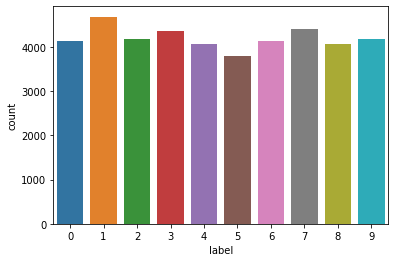

In [31]:
#Check whether the count for each label
sns.countplot(digits['label'])

## Data Preparation

Let's conduct some data preparation steps before modeling. 

In [7]:
# splitting into X and y
X = digits.drop("label", axis = 1)
y = digits['label']

In [8]:
# scaling the features
X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.8, random_state = 101)

## Model Building

Let's fist build two basic models - linear and non-linear with default hyperparameters, and compare the accuracies.

In [9]:
# linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_test)


In [10]:
# confusion matrix and accuracy
# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.913125 

[[3188    0   10    5   11   20   32    3   15    1]
 [   0 3677   14   11    5    7    4    8   30    4]
 [  36   29 3027   54   55   10   30   42   48   12]
 [  13   12  104 3051    9  181    5   21   54   25]
 [   8   14   33    2 3057    4   25   31    6  110]
 [  30   23   29  136   44 2622   44   12   72   27]
 [  26   11   44    4   28   33 3113    0   18    0]
 [   7   24   36   19   59    9    2 3210    4  134]
 [  13   46   50  120   21  110   30   18 2843   21]
 [  19   17   21   22  172   20    4  161   26 2893]]


The linear model gives approx. 91% accuracy. Let's look at a sufficiently non-linear model with randomly chosen hyperparameters.

In [11]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='rbf')

# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

C:\Users\I332724\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [13]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.9396428571428571 

[[3195    0   19    5    4   11   32    4   14    1]
 [   0 3689   23   12    8    3    7    6    8    4]
 [  15   15 3144   29   31    5   18   37   43    6]
 [   5    8   92 3191    5   73    6   31   43   21]
 [   3    7   57    1 3099    9   19   21    7   67]
 [  15   10   37   66   16 2776   53   15   32   19]
 [  19    5   46    1   12   31 3149    2   12    0]
 [   6   21   66   11   25    3    0 3285    3   84]
 [  14   24   40   63   14   62   22   19 2996   18]
 [  12   10   38   40   80    6    0   97   24 3048]]


The non-linear model gives approx. 93% accuracy. Thus, going forward, let's choose hyperparameters corresponding to non-linear models.

## Grid Search: Hyperparameter Tuning

Let's now tune the model to find the optimal values of C and gamma corresponding to an RBF kernel. We'll use 5-fold cross validation.

In [14]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2,1e-3,1e-4],
                     'C': [1, 10, 20]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs=-1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 89.6min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [1, 10, 20], 'gamma': [0.01, 0.001, 0.0001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [15]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3065.083153,1451.707483,20.141059,0.643979,1,0.01,"{'C': 1, 'gamma': 0.01}",0.752381,0.750595,0.747024,...,0.741310,0.010784,9,1.000000,0.999851,0.999851,1.000000,1.000000,0.999940,0.000073
1,40.525775,0.394434,11.546783,0.398354,1,0.001,"{'C': 1, 'gamma': 0.001}",0.935119,0.926786,0.935119,...,0.930833,0.004216,3,0.972321,0.971429,0.971429,0.972173,0.973214,0.972113,0.000663
2,62.862176,5.331961,17.179554,1.392728,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.910119,0.905952,0.907738,...,0.903095,0.006075,6,0.916518,0.917708,0.916518,0.921577,0.919940,0.918452,0.002001
3,178.778946,5.696492,22.971037,3.372576,10,0.01,"{'C': 10, 'gamma': 0.01}",0.766071,0.772619,0.765476,...,0.760476,0.009705,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,36.526268,1.548380,10.705065,0.495551,10,0.001,"{'C': 10, 'gamma': 0.001}",0.941071,0.938690,0.945833,...,0.939405,0.003865,1,0.999405,0.999554,0.999405,0.999107,0.999256,0.999345,0.000152
5,29.292413,2.966368,10.399242,1.136513,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.933929,0.923214,0.931548,...,0.927262,0.004678,5,0.957887,0.959970,0.959375,0.957738,0.959077,0.958810,0.000865
6,170.143095,21.724754,17.132582,2.501743,20,0.01,"{'C': 20, 'gamma': 0.01}",0.766071,0.772619,0.765476,...,0.760476,0.009705,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,27.035307,0.454337,8.186708,0.143275,20,0.001,"{'C': 20, 'gamma': 0.001}",0.940476,0.936905,0.946429,...,0.939405,0.003810,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,18.219159,0.467986,6.890051,0.733203,20,0.0001,"{'C': 20, 'gamma': 0.0001}",0.939881,0.926190,0.931548,...,0.930119,0.005305,4,0.969792,0.971577,0.970536,0.969643,0.971429,0.970595,0.000802


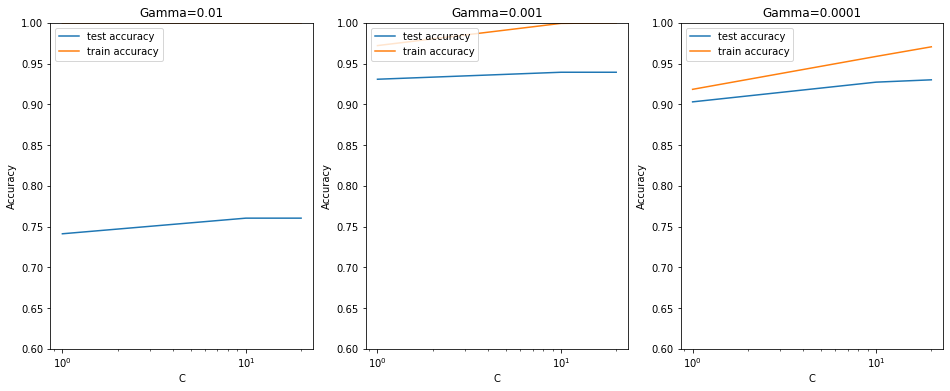

In [16]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3   
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


The plots above show some useful insights:
- Non-linear models (high gamma) perform *much better* than the linear ones
- At any value of gamma, a high value of C leads to better performance
- None of the models tend to overfit (even the complex ones), since the training and test accuracies closely follow each other

This suggests that the problem and the data is **inherently non-linear** in nature, and a complex model will outperform simple, linear models in this case.

Let's now choose the best hyperparameters. 

In [17]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9394047619047619 corresponding to hyperparameters {'C': 10, 'gamma': 0.001}


### Building and Evaluating the Final Model

Let's now build and evaluate the final model, i.e. the model with highest test accuracy.

In [18]:
# model with optimal hyperparameters

# model
model = SVC(C=10, gamma=0.001, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# metrics
print("accuracy", metrics.accuracy_score(y_test, y_pred), "\n")
print(metrics.confusion_matrix(y_test, y_pred), "\n")



accuracy 0.9477083333333334 

[[3211    0   19    2    2   12   26    3    8    2]
 [   0 3692   26    9    6    3    5    9    7    3]
 [  13   12 3165   29   29    6   20   40   21    8]
 [   4    5   77 3232    4   79    1   23   31   19]
 [   5    8   42    1 3117    5   20   19    9   64]
 [  15    8   33   61   15 2815   35   11   31   15]
 [  19    5   44    1   12   18 3167    1   10    0]
 [   5   17   52   12   29    4    1 3322    4   58]
 [   7   16   42   53   15   51   18   16 3044   10]
 [   9    9   33   20   81   10    0   94   21 3078]] 



## Conclusion

The accuracy achieved using a non-linear kernel (~0.94) is mush higher than that of a linear one (~0.91). We can conclude that the problem is highly non-linear in nature.

Also, The class accuracy can be calculated using the classification_report method

In [30]:
print(metrics.classification_report(y_test, y_pred), "\n")

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3285
           1       0.98      0.98      0.98      3760
           2       0.90      0.95      0.92      3343
           3       0.95      0.93      0.94      3475
           4       0.94      0.95      0.94      3290
           5       0.94      0.93      0.93      3039
           6       0.96      0.97      0.96      3277
           7       0.94      0.95      0.94      3504
           8       0.96      0.93      0.94      3272
           9       0.95      0.92      0.93      3355

    accuracy                           0.95     33600
   macro avg       0.95      0.95      0.95     33600
weighted avg       0.95      0.95      0.95     33600
 



It is seen that all class measures are equally distributed. 